In [3]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# 1. Cargar y limpiar el dataset
df = pd.read_csv("dataset_elpino.csv", sep=";", encoding="utf-8", on_bad_lines='skip')
df = df.dropna(axis=1, how='all')  # Eliminar columnas vacías
df = df.dropna(axis=0, how='all')  # Eliminar filas vacías
df["Sexo (Desc)"] = df["Sexo (Desc)"].str.strip().map({"Hombre": 0, "Mujer": 1})  # Normalizar sexo
df["Edad en años"] = pd.to_numeric(df["Edad en años"], errors='coerce')  # Convertir a numérico
df = df.dropna(subset=["Edad en años"])  # Eliminar filas con edades nulas
df = df[df["Edad en años"] <= 100]  # Eliminar registros con edad > 100
df = df.drop_duplicates()  # Eliminar duplicados


In [5]:
# 2. Unificar el texto clínico (unir columnas de texto)
texto_columnas = df.columns[0:65]
df["texto"] = df[texto_columnas].apply(lambda fila: " ".join(fila.values.astype(str)), axis=1)


In [6]:
# 3. Filtrar las 20 clases más frecuentes (GRD)
top_grd = df["GRD"].value_counts().head(20).index
df_filtrado = df[df["GRD"].isin(top_grd)]


In [7]:
# 4. Tomar una muestra de 15,000 registros
df_sample = df_filtrado.sample(n=min(15000, len(df_filtrado)), random_state=42)


In [8]:
# 5. Vectorizar el texto clínico
vectorizer = CountVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df_sample["texto"]).toarray()


In [9]:
# 6. Combinar características estructuradas (edad y sexo) con el texto vectorizado
X_structured = df_sample[["Edad en años", "Sexo (Desc)"]].values
X = np.concatenate([X_text, X_structured], axis=1)
y = df_sample["GRD"]


In [10]:
# 7. Dividir los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# 8. Entrenar el modelo de regresión logística con 1000 iteraciones
modelo = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga',multi_class='multinomial')
modelo.fit(X_train, y_train)


C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')

In [24]:
# 9. Evaluar el modelo y generar reporte de clasificación
y_pred = modelo.predict(X_test)

# Reporte de clasificación
reporte = classification_report(y_test, y_pred, output_dict=True)
print("📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# 10. Matriz de confusión
matriz = confusion_matrix(y_test, y_pred)
print("🧊 Matriz de Confusión:")
print(matriz)


📋 Reporte de clasificación:
                                                                                             precision    recall  f1-score   support

                        041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEOSTOMÍA W/MCC       0.91      0.72      0.81        87
                                044153 - MH INFECCIONES E INFLAMACIONES RESPIRATORIAS W/MCC       0.55      0.83      0.66        75
                                             044163 - MH NEUMONÍA SIMPLE Y TOS FERINA W/MCC       0.73      0.45      0.56        77
                                                     044183 - MH BRONQUIOLITIS Y ASMA W/MCC       0.77      0.89      0.83        54
                                                   054123 - MH INSUFICIENCIA CARDIACA W/MCC       0.78      0.51      0.62        63
                                                  061131 - PH PROCEDIMIENTOS SOBRE APÉNDICE       0.57      0.90      0.70        77
                                  061201

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [25]:
# 1. Definir modelos candidatos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 2. Entrenar y evaluar modelos
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = modelo.predict(X_test)  # Realizar predicciones
    resultados[nombre] = classification_report(y_test, y_pred, output_dict=True)  # Almacenar el reporte de clasificación


C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
# 3. Crear un DataFrame con las métricas
modelos_comparacion = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1-score"])
for nombre, reporte in resultados.items():
    # Extraer métricas clave del reporte
    accuracy = reporte['accuracy']
    precision_promedio = reporte['macro avg']['precision']
    recall_promedio = reporte['macro avg']['recall']
    f1_score_promedio = reporte['macro avg']['f1-score']
    
    # Agregar al DataFrame
    modelos_comparacion.loc[nombre] = [accuracy, precision_promedio, recall_promedio, f1_score_promedio]

# Mostrar resultados
print(modelos_comparacion.to_string(index=True))




                     Accuracy  Precision    Recall  F1-score
Regresión Logística  0.923345   0.920971  0.925224  0.921443
Random Forest        0.904762   0.917645  0.876960  0.888682
SVM                  0.926829   0.922259  0.924897  0.922417
KNN                  0.735192   0.767639  0.658437  0.655285


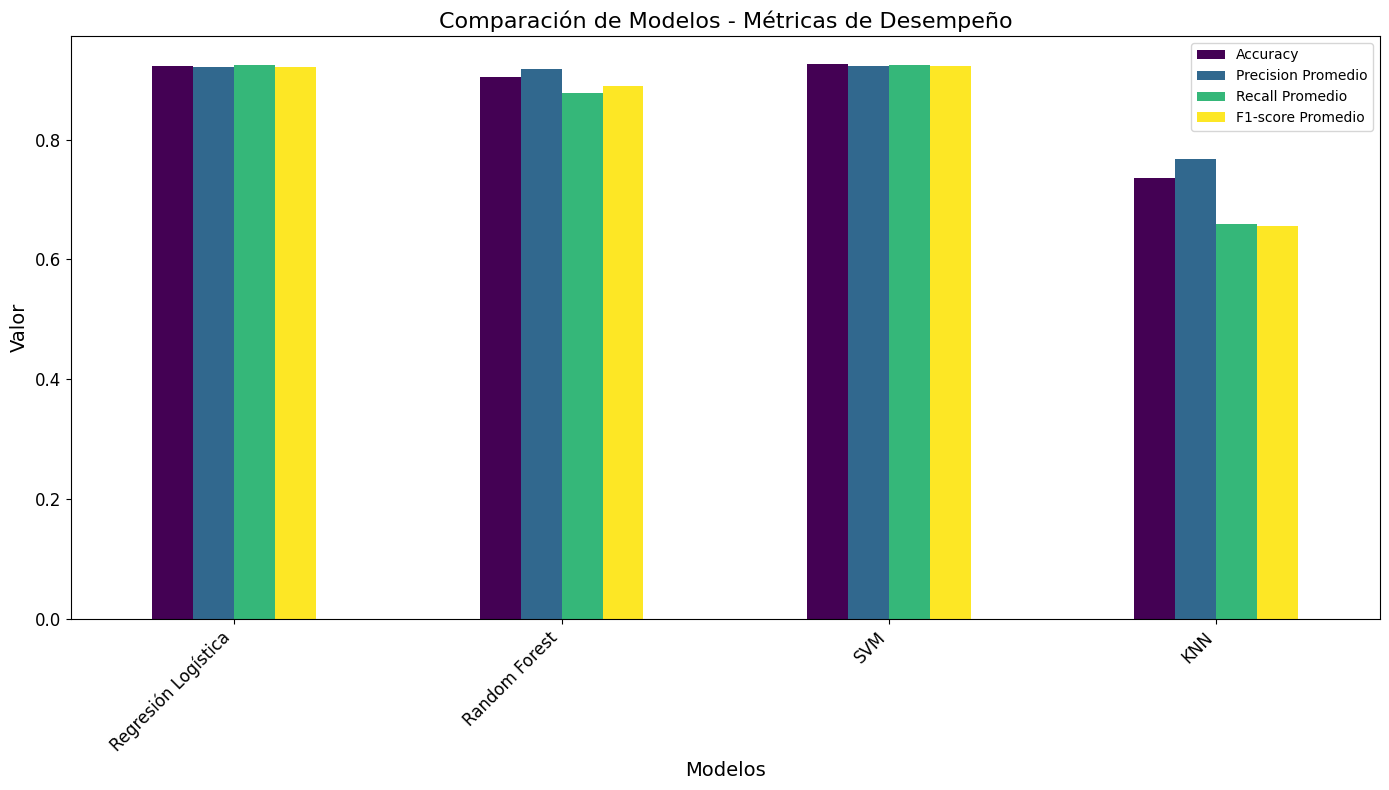

In [16]:
# 4. Gráfico de comparación de modelos
modelos_comparacion.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title("Comparación de Modelos - Métricas de Desempeño", fontsize=16)
plt.ylabel("Valor", fontsize=14)
plt.xlabel("Modelos", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Hugo\AppData\Local\Temp\ipykernel_14884\148825807.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


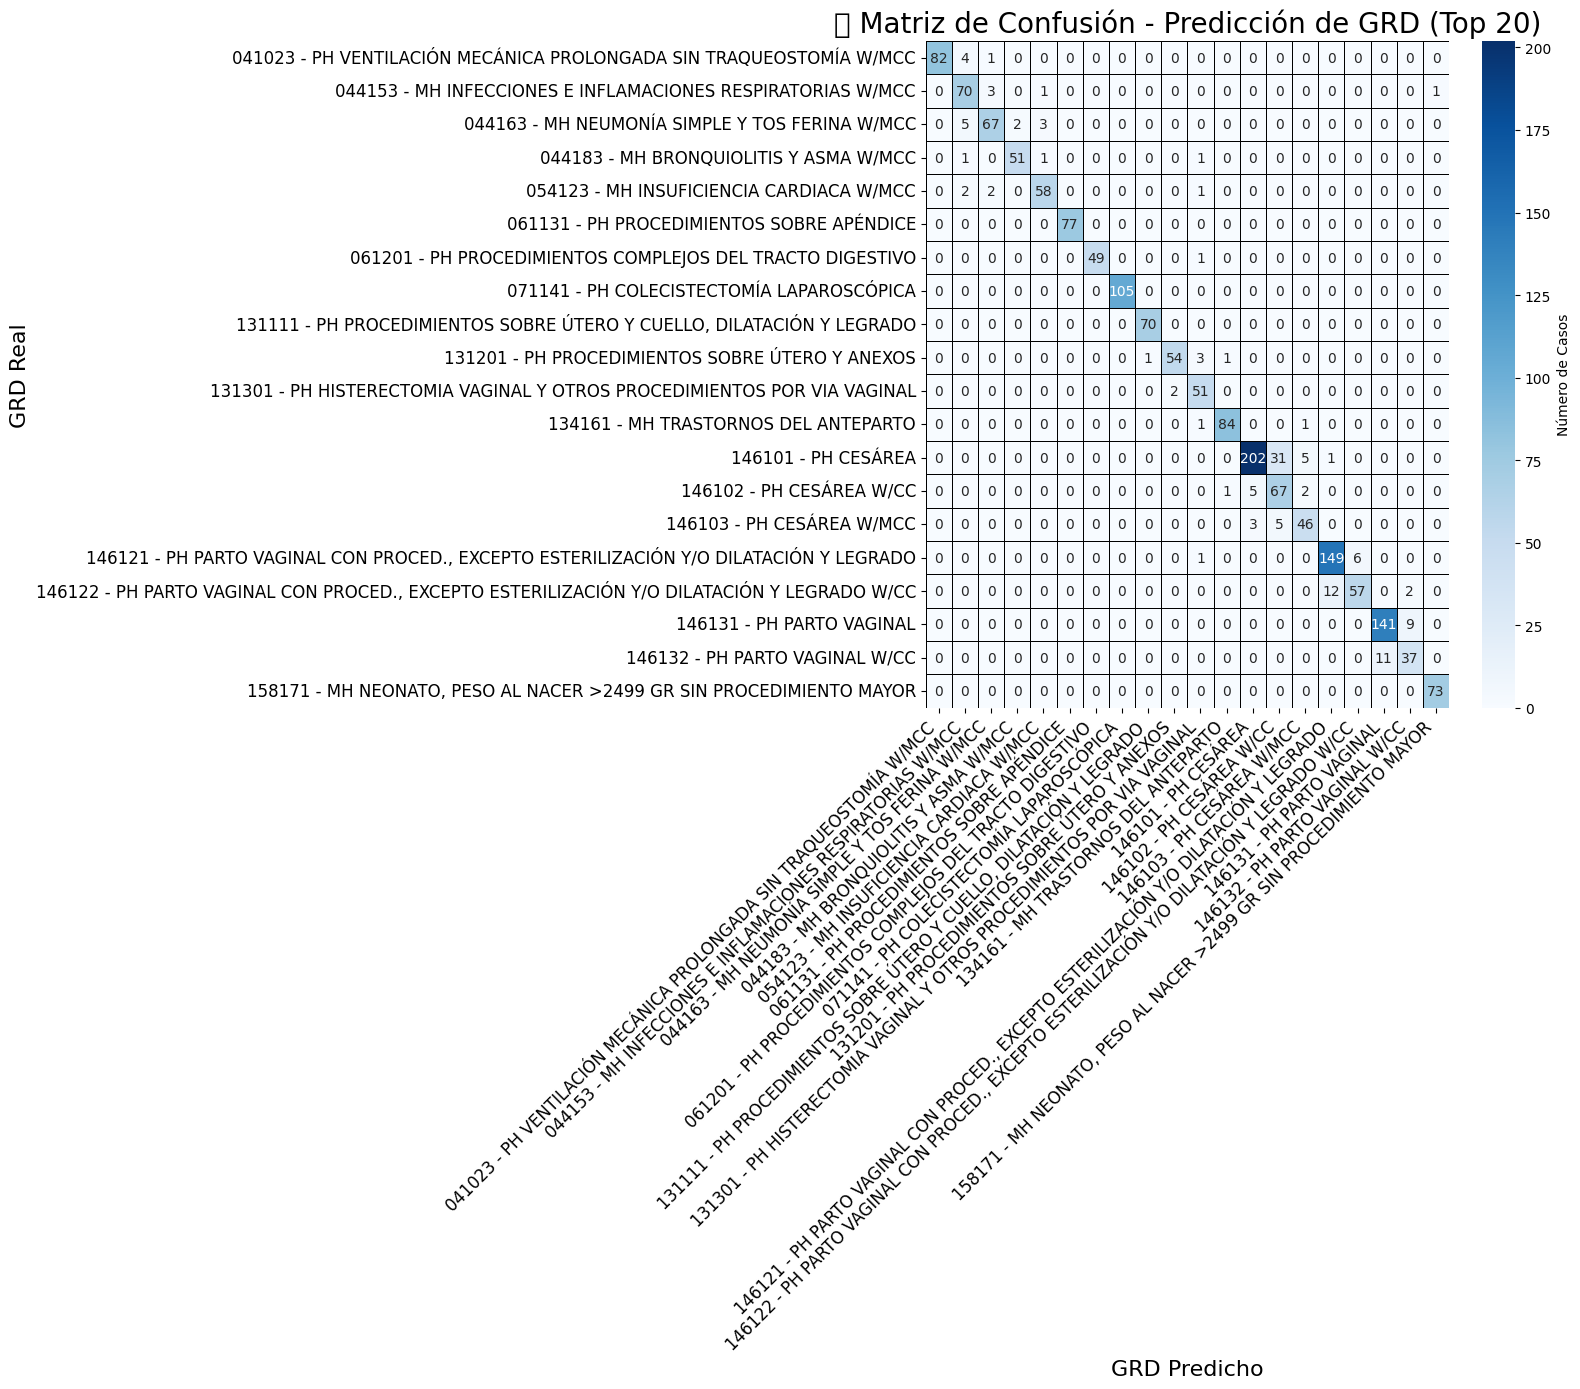

In [17]:
# 11. Mejorar visualización de la matriz de confusión
plt.figure(figsize=(16, 14))  # Aumentamos aún más el tamaño de la figura para mejorar la visualización

# Creamos la matriz de confusión con etiquetas mejoradas
sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", 
            xticklabels=modelo.classes_, yticklabels=modelo.classes_,
            cbar_kws={'label': 'Número de Casos'},
            linewidths=0.5, linecolor='black', annot_kws={"size": 10})

# Mejoramos el título y las etiquetas
plt.title("📊 Matriz de Confusión - Predicción de GRD (Top 20)", fontsize=20)
plt.xlabel("GRD Predicho", fontsize=16)
plt.ylabel("GRD Real", fontsize=16)

# Mejorar la legibilidad de las etiquetas en el eje X y Y
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotamos las etiquetas del eje X a 45 grados, alineándolas a la derecha
plt.yticks(rotation=0, fontsize=12)  # Deja las etiquetas del eje Y horizontales para legibilidad

# Ajustar el espacio para asegurar que todo encaje correctamente
plt.tight_layout()

# Mostrar el gráfico
plt.show()


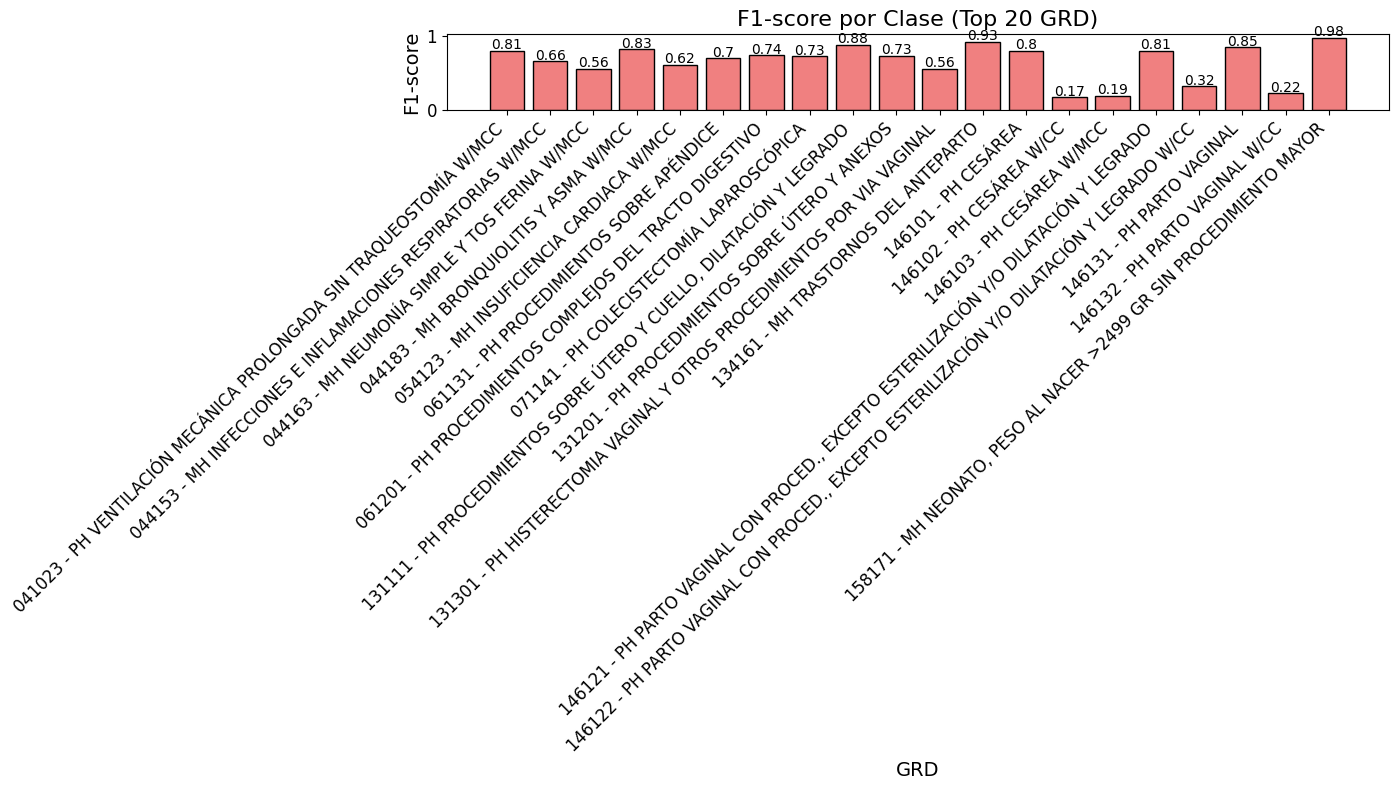

In [18]:
# 12. Mejorar gráfico de F1-score por clase
f1_scores = [reporte[str(clase)]['f1-score'] if str(clase) in reporte else 0 for clase in modelo.classes_]

plt.figure(figsize=(14, 8))
bars = plt.bar(modelo.classes_, f1_scores, color='lightcoral', edgecolor='black')

plt.title("F1-score por Clase (Top 20 GRD)", fontsize=16)
plt.xlabel("GRD", fontsize=14)
plt.ylabel("F1-score", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\Hugo\AppData\Local\Temp\ipykernel_14884\2937754119.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


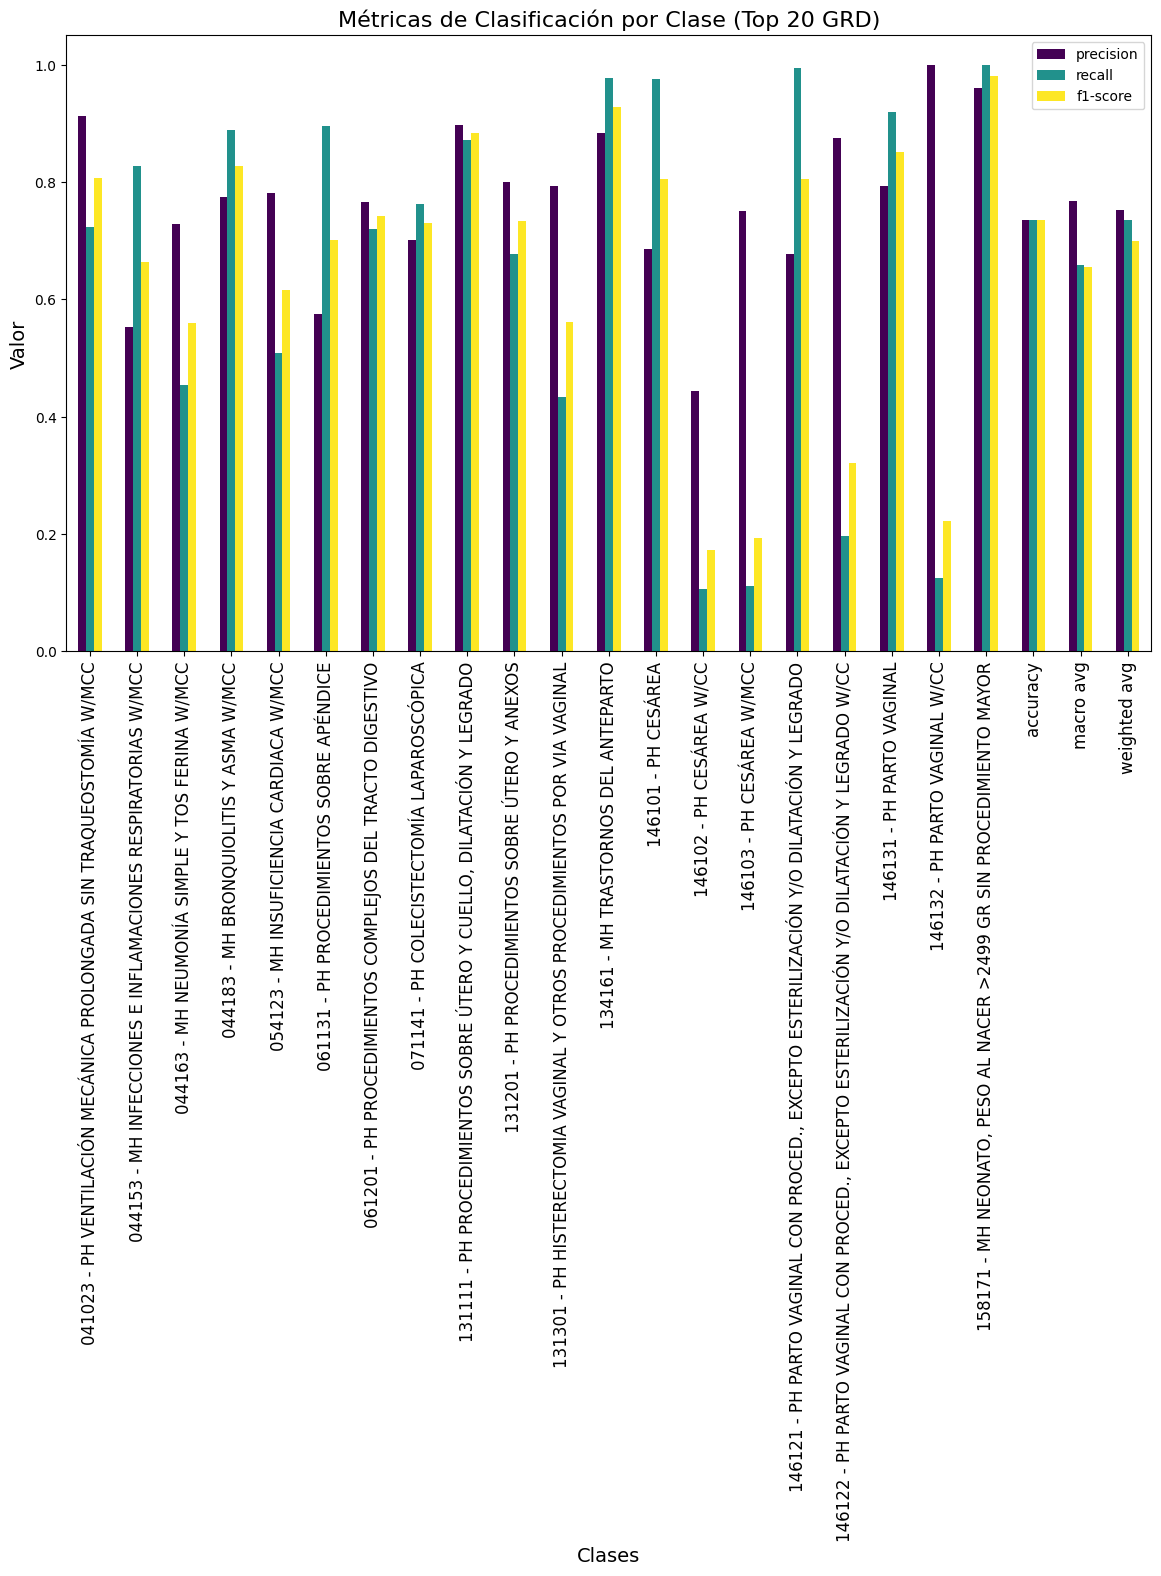

In [19]:
# 13. Gráfico de métricas por clase (Precision, Recall, F1-score)
metrics = ['precision', 'recall', 'f1-score']
df_reporte = pd.DataFrame(reporte).transpose()

df_reporte[metrics].plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title("Métricas de Clasificación por Clase (Top 20 GRD)", fontsize=16)
plt.ylabel("Valor", fontsize=14)
plt.xlabel("Clases", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Hugo\AppData\Local\Temp\ipykernel_14884\2174470043.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustar todo para que encaje en la figura


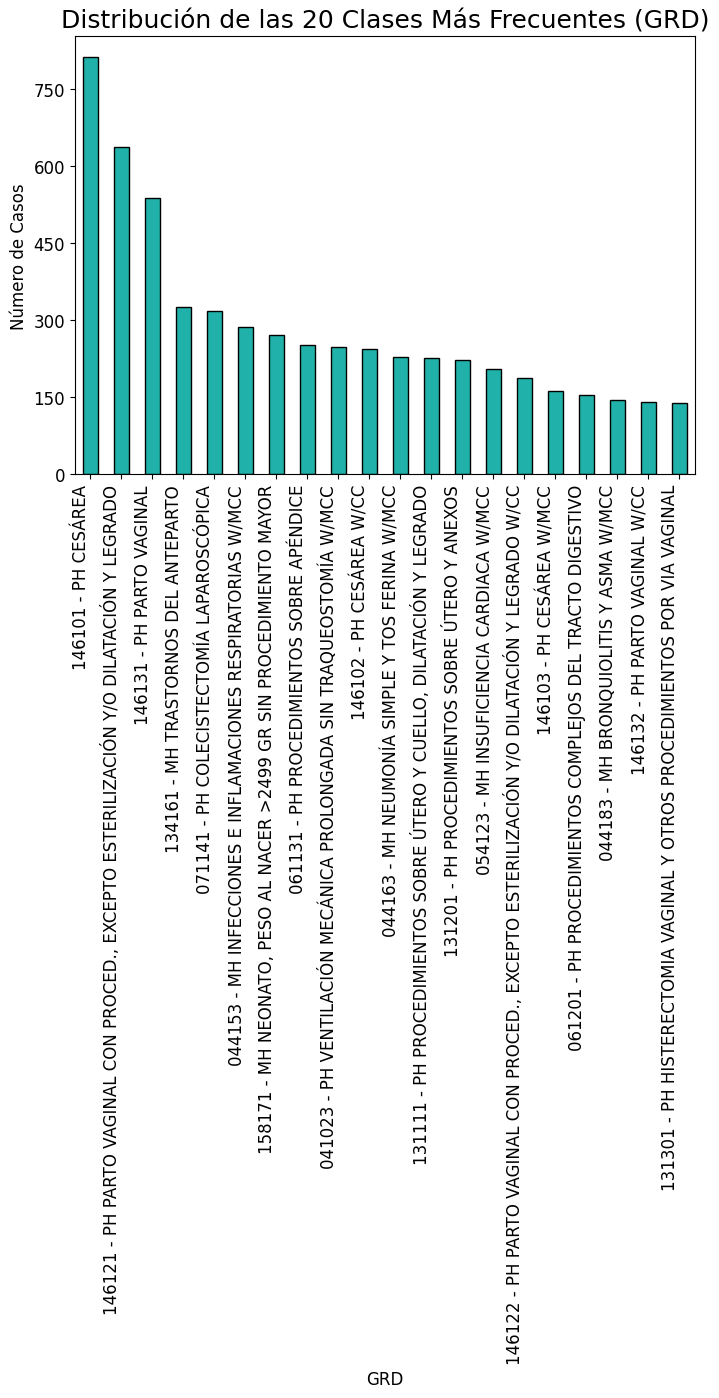

In [20]:
# 14. Mejorar gráfico de distribución de las 20 clases más frecuentes (GRD)
plt.figure(figsize=(8,6))  # Aumentar el tamaño de la figura
df['GRD'].value_counts().head(20).plot(kind='bar', color='lightseagreen', edgecolor='black')

# Título y etiquetas
plt.title('Distribución de las 20 Clases Más Frecuentes (GRD)', fontsize=18)
plt.xlabel('GRD', fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)

# Mejorar la legibilidad de las etiquetas
plt.xticks(ha='right', fontsize=12)  # Rotar las etiquetas a 45 grados y alinearlas a la derecha
plt.yticks(fontsize=12)

# Ajustar los valores en el eje Y para ser más legibles (usando formato de miles)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Ajustar los ticks en el eje Y para que tenga más puntos intermedios
plt.yticks(np.arange(0, df['GRD'].value_counts().head(20).max(), step=150))  # Ajustar intervalo entre los ticks a 150 unidades

# Ajustar el espacio entre las etiquetas
plt.subplots_adjust(bottom=0.15)  # Ajustar espacio inferior para que las etiquetas no se corten

# Mostrar el gráfico
plt.tight_layout()  # Ajustar todo para que encaje en la figura
plt.show()


La edad media del dataset es: 39.79972251127298


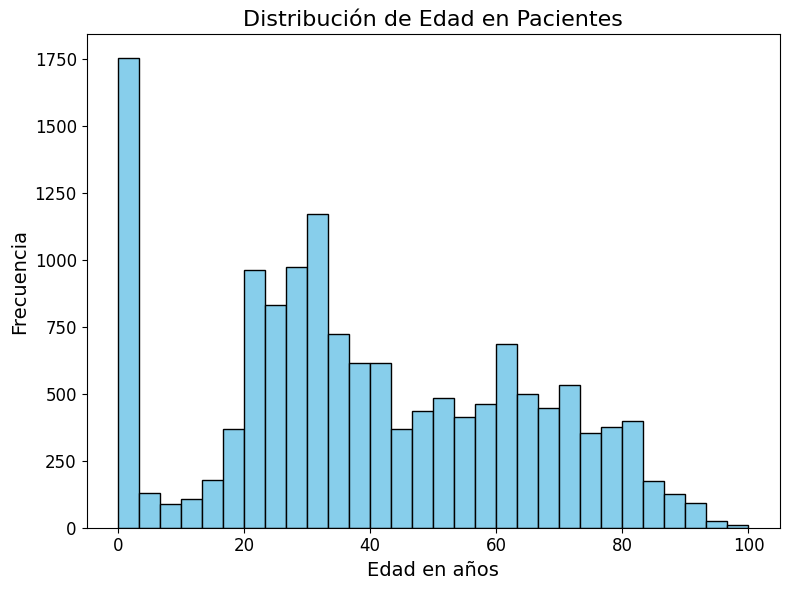

In [21]:
# 15. Gráfico de la distribución de edad
edad_media = df["Edad en años"].mean()
print("La edad media del dataset es:", edad_media)
plt.figure(figsize=(8, 6))
plt.hist(df["Edad en años"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de Edad en Pacientes", fontsize=16)
plt.xlabel("Edad en años", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Cantidad de hombres: 4875
Cantidad de mujeres: 9540


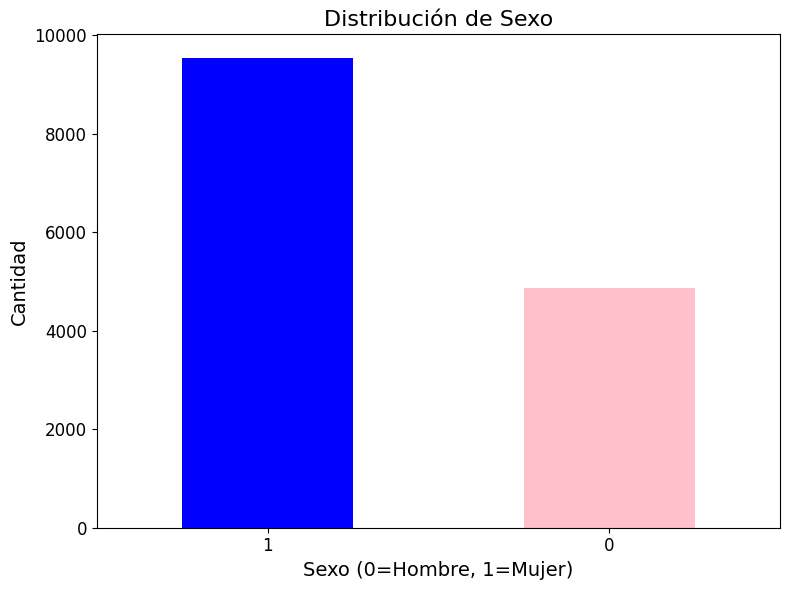

In [22]:
# 16. Gráfico de la distribución de sexo
hombres = df[df["Sexo (Desc)"] == 0].shape[0]  # Cantidad de hombres (0)
mujeres = df[df["Sexo (Desc)"] == 1].shape[0]  # Cantidad de mujeres (1)

print("Cantidad de hombres:", hombres)
print("Cantidad de mujeres:", mujeres)

plt.figure(figsize=(8, 6))
df["Sexo (Desc)"].value_counts().plot(kind="bar", color=['blue', 'pink'])
plt.title("Distribución de Sexo", fontsize=16)
plt.xlabel("Sexo (0=Hombre, 1=Mujer)", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
